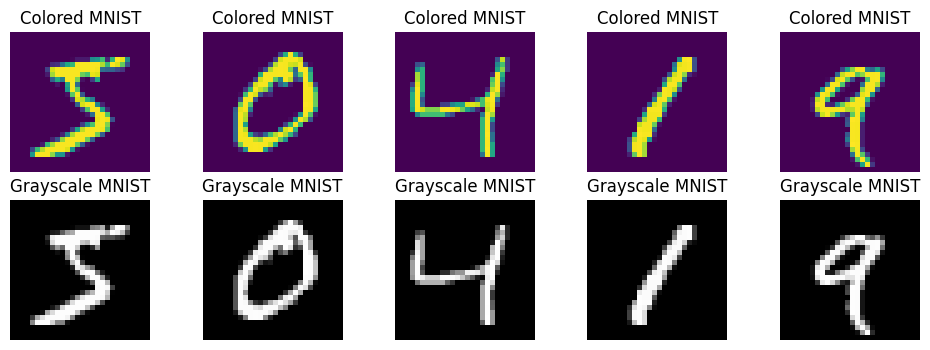

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from PIL import Image
import numpy as np
import os

# Set download path for datasets
data_path = "/content/sample_data"

# Custom Dataset for Colored MNIST
class ColoredMNISTDataset(Dataset):
    def __init__(self, grayscale_dataset):
        self.grayscale_dataset = grayscale_dataset
        self.transform_color = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Replicate grayscale to RGB
            transforms.ColorJitter()  # Add random color jitter
        ])

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image = self.transform_color(grayscale_image)
        return color_image, grayscale_image

# Load Grayscale MNIST
grayscale_transform = transforms.ToTensor()
grayscale_mnist = MNIST(root=data_path, train=True, download=True, transform=grayscale_transform)

# Load Colored MNIST
colored_mnist = ColoredMNISTDataset(grayscale_mnist)

# Visualize Samples from Both Datasets
def show_samples(color_ds, gray_ds, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))
    for i in range(num_samples):
        color_img, gray_img = color_ds[i][0], gray_ds[i][0]
        axes[0, i].imshow(color_img.permute(1, 2, 0).numpy())
        axes[0, i].set_title("Colored MNIST")
        axes[0, i].axis('off')
        axes[1, i].imshow(gray_img[0], cmap='gray')
        axes[1, i].set_title("Grayscale MNIST")
        axes[1, i].axis('off')
    plt.show()

show_samples(colored_mnist, grayscale_mnist)



Epoch [1/10], Loss: 0.0230
Epoch [2/10], Loss: 0.0086
Epoch [3/10], Loss: 0.0069
Epoch [4/10], Loss: 0.0061
Epoch [5/10], Loss: 0.0056
Epoch [6/10], Loss: 0.0052
Epoch [7/10], Loss: 0.0050
Epoch [8/10], Loss: 0.0048
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0046


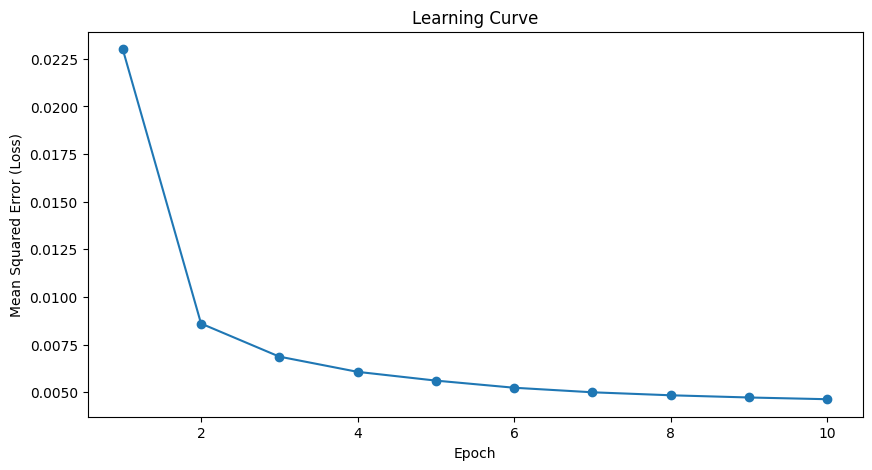

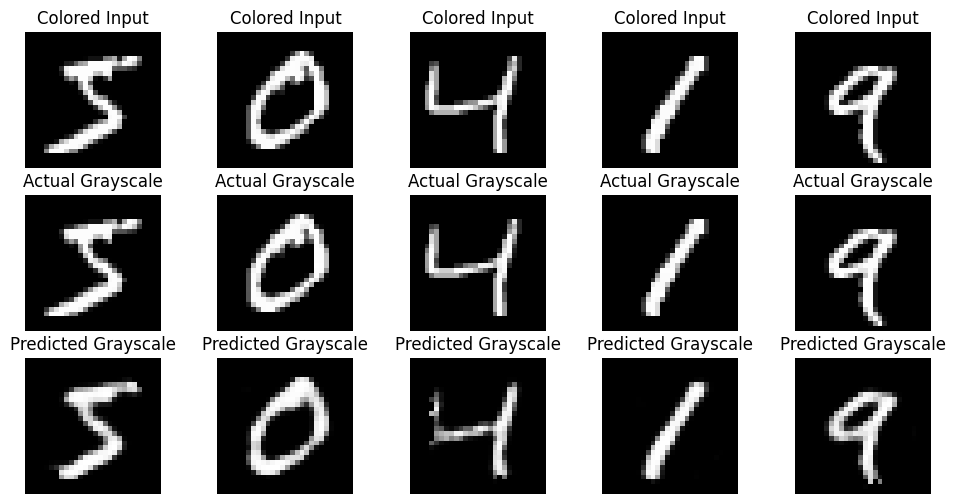

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from PIL import Image
import numpy as np
import os

# Set download path for datasets
data_path = "/content/sample_data"

# Custom Dataset for Colored MNIST
class ColoredMNISTDataset(Dataset):
    def __init__(self, grayscale_dataset):
        self.grayscale_dataset = grayscale_dataset
        self.transform_color = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Replicate grayscale to RGB
            transforms.ColorJitter()  # Add random color jitter
        ])

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        grayscale_image = transforms.ToPILImage()(grayscale_image)  # Convert tensor to PIL image
        color_image = self.transform_color(grayscale_image)
        color_image = transforms.ToTensor()(color_image)  # Ensure color image is tensor with 3 channels
        return color_image, transforms.ToTensor()(grayscale_image)

# Load Grayscale MNIST
grayscale_transform = transforms.ToTensor()
grayscale_mnist = MNIST(root=data_path, train=True, download=True, transform=grayscale_transform)

# Load Colored MNIST
colored_mnist = ColoredMNISTDataset(grayscale_mnist)


# DataLoader
batch_size = 64
train_loader = DataLoader(colored_mnist, batch_size=batch_size, shuffle=True)

# CNN Regression Model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),  # Output size for 28x28 grayscale image
            nn.Sigmoid()  # Scale output to [0, 1] range
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, 1, 28, 28)  # Reshape to grayscale image format

# Instantiate Model, Loss, and Optimizer
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for color_imgs, gray_imgs in dataloader:
            gray_imgs = gray_imgs.to(torch.float32)
            color_imgs = color_imgs

            optimizer.zero_grad()
            outputs = model(color_imgs)
            loss = criterion(outputs, gray_imgs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return losses

# Training the model
epochs = 10
losses = train(model, train_loader, criterion, optimizer, epochs)

# Plotting Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.show()

# Visualize Predictions
def show_predictions(model, dataset, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 6))
    for i in range(num_samples):
        color_img, gray_img = dataset[i]
        color_img = color_img.unsqueeze(0)
        with torch.no_grad():
            predicted_gray_img = model(color_img).squeeze().cpu().numpy()

        axes[0, i].imshow(color_img[0].permute(1, 2, 0).numpy())
        axes[0, i].set_title("Colored Input")
        axes[0, i].axis('off')

        axes[1, i].imshow(gray_img[0], cmap='gray')
        axes[1, i].set_title("Actual Grayscale")
        axes[1, i].axis('off')

        axes[2, i].imshow(predicted_gray_img, cmap='gray')
        axes[2, i].set_title("Predicted Grayscale")
        axes[2, i].axis('off')
    plt.show()

# Show predictions
show_predictions(model, colored_mnist)


Epoch [1/10], Classification Loss: 2.3070, Regression Loss: 0.0716
Epoch [2/10], Classification Loss: 2.3062, Regression Loss: 0.0579
Epoch [3/10], Classification Loss: 2.3062, Regression Loss: 0.0411
Epoch [4/10], Classification Loss: 2.3058, Regression Loss: 0.0320
Epoch [5/10], Classification Loss: 2.3054, Regression Loss: 0.0268
Epoch [6/10], Classification Loss: 2.3057, Regression Loss: 0.0233
Epoch [7/10], Classification Loss: 2.3054, Regression Loss: 0.0206
Epoch [8/10], Classification Loss: 2.3053, Regression Loss: 0.0188
Epoch [9/10], Classification Loss: 2.3057, Regression Loss: 0.0173
Epoch [10/10], Classification Loss: 2.3054, Regression Loss: 0.0163


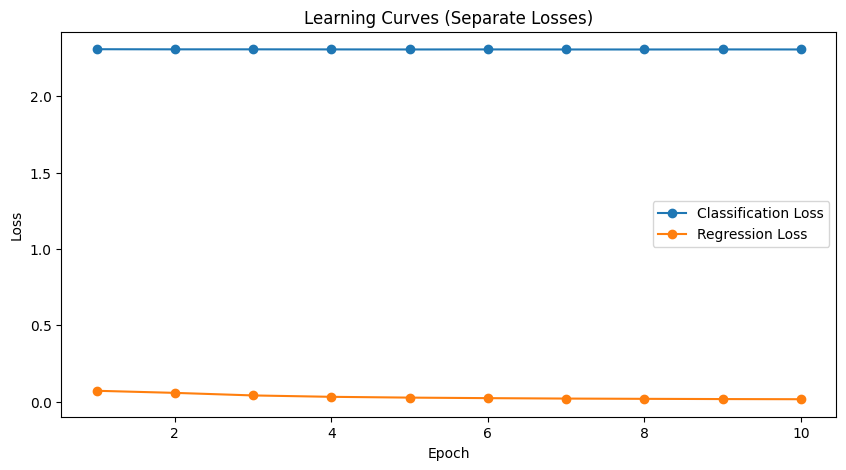

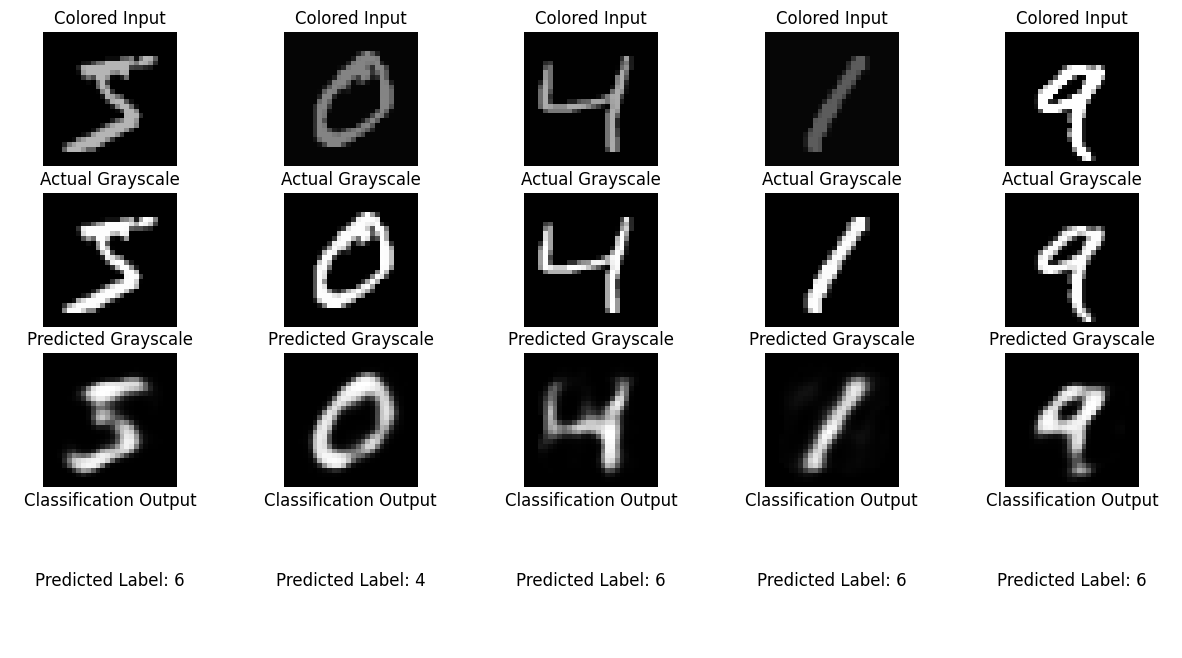

Epoch [1/10], Combined Loss: 2.3205
Epoch [2/10], Combined Loss: 2.3196
Epoch [3/10], Combined Loss: 2.3190
Epoch [4/10], Combined Loss: 2.3185
Epoch [5/10], Combined Loss: 2.3182
Epoch [6/10], Combined Loss: 2.3179
Epoch [7/10], Combined Loss: 2.3177
Epoch [8/10], Combined Loss: 2.3173
Epoch [9/10], Combined Loss: 2.3169
Epoch [10/10], Combined Loss: 2.3171


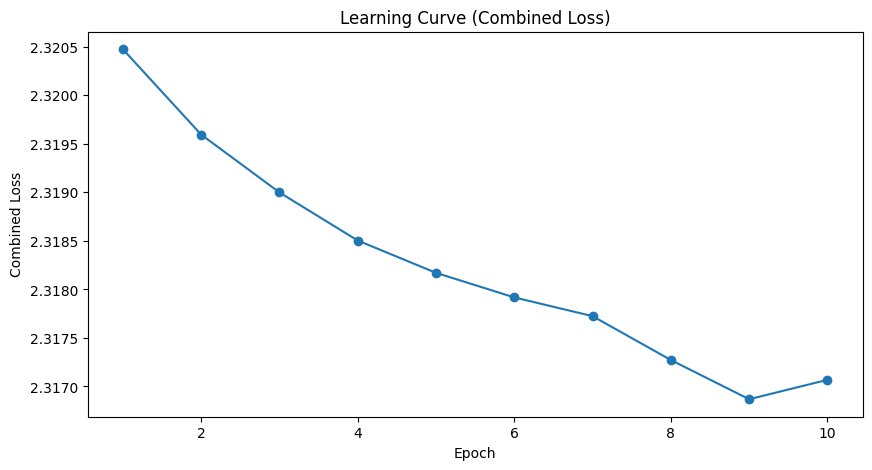

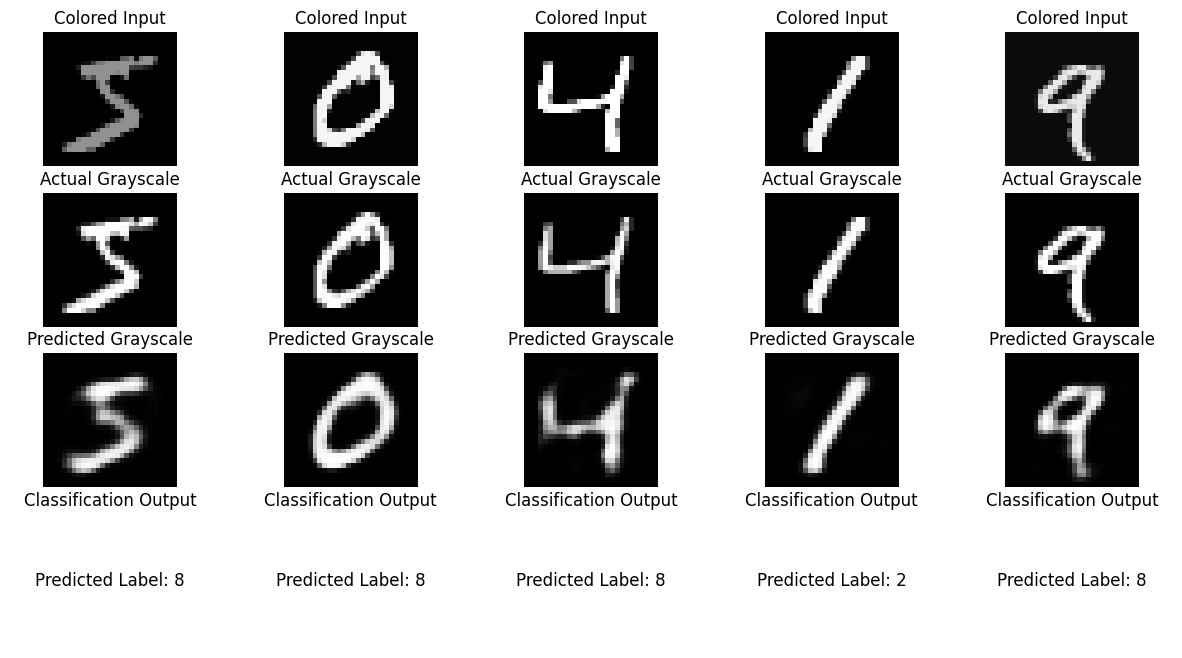

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os

# Set download path for datasets
data_path = "/content/sample_data"

# Custom Dataset for Colored MNIST
class ColoredMNISTDataset(Dataset):
    def __init__(self, grayscale_dataset):
        self.grayscale_dataset = grayscale_dataset
        self.transform_color = transforms.Compose([
            transforms.ToPILImage(),  # Convert tensor to PIL image
            transforms.Grayscale(num_output_channels=3),  # Replicate grayscale to RGB
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # Add random color jitter
            transforms.ToTensor()  # Convert back to tensor
        ])

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image = self.transform_color(grayscale_image)
        return color_image, grayscale_image

# Load Grayscale MNIST
grayscale_transform = transforms.ToTensor()
grayscale_mnist = MNIST(root=data_path, train=True, download=True, transform=grayscale_transform)

# Load Colored MNIST
colored_mnist = ColoredMNISTDataset(grayscale_mnist)

# DataLoader
batch_size = 64
train_loader = DataLoader(colored_mnist, batch_size=batch_size, shuffle=True)

# CNN Model for Multi-Task Learning
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_classification = nn.Linear(128, 10)  # Classification output (10 classes for MNIST digits)
        self.fc_regression = nn.Linear(128, 28 * 28)  # Regression output (28x28 grayscale image)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers_shared(x)
        classification_output = self.fc_classification(x)
        regression_output = torch.sigmoid(self.fc_regression(x)).view(-1, 1, 28, 28)
        return classification_output, regression_output

# Instantiate Model, Loss, and Optimizer
model = MultiTaskModel()
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function with Separate Losses
def train_separate_loss(model, dataloader, classification_criterion, regression_criterion, optimizer, epochs=10):
    model.train()
    classification_losses = []
    regression_losses = []
    for epoch in range(epochs):
        classification_epoch_loss = 0
        regression_epoch_loss = 0
        for color_imgs, gray_imgs in dataloader:
            gray_imgs = gray_imgs.to(torch.float32)
            color_imgs = color_imgs
            labels = torch.randint(0, 10, (color_imgs.size(0),))  # Random dummy labels for classification task

            optimizer.zero_grad()
            classification_output, regression_output = model(color_imgs)

            # Separate Losses
            classification_loss = classification_criterion(classification_output, labels)
            regression_loss = regression_criterion(regression_output, gray_imgs)

            # Update separately
            classification_loss.backward(retain_graph=True)
            regression_loss.backward()
            optimizer.step()

            classification_epoch_loss += classification_loss.item()
            regression_epoch_loss += regression_loss.item()

        avg_classification_loss = classification_epoch_loss / len(dataloader)
        avg_regression_loss = regression_epoch_loss / len(dataloader)
        classification_losses.append(avg_classification_loss)
        regression_losses.append(avg_regression_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Classification Loss: {avg_classification_loss:.4f}, Regression Loss: {avg_regression_loss:.4f}")
    return classification_losses, regression_losses

# Training the model with Separate Losses
epochs = 10
classification_losses, regression_losses = train_separate_loss(model, train_loader, classification_criterion, regression_criterion, optimizer, epochs)

# Plotting Separate Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), classification_losses, marker='o', label='Classification Loss')
plt.plot(range(1, epochs + 1), regression_losses, marker='o', label='Regression Loss')
plt.title('Learning Curves (Separate Losses)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize Predictions for Separate Loss
def show_separate_loss_predictions(model, dataset, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 8))
    for i in range(num_samples):
        color_img, gray_img = dataset[i]
        color_img = color_img.unsqueeze(0)
        with torch.no_grad():
            classification_output, predicted_gray_img = model(color_img)
            predicted_gray_img = predicted_gray_img.squeeze().cpu().numpy()
            predicted_label = classification_output.argmax(dim=1).item()

        axes[0, i].imshow(color_img[0].permute(1, 2, 0).numpy())
        axes[0, i].set_title("Colored Input")
        axes[0, i].axis('off')

        axes[1, i].imshow(gray_img[0], cmap='gray')
        axes[1, i].set_title("Actual Grayscale")
        axes[1, i].axis('off')

        axes[2, i].imshow(predicted_gray_img, cmap='gray')
        axes[2, i].set_title("Predicted Grayscale")
        axes[2, i].axis('off')

        axes[3, i].text(0.5, 0.5, f"Predicted Label: {predicted_label}", fontsize=12, ha='center', va='center')
        axes[3, i].set_title("Classification Output")
        axes[3, i].axis('off')
    plt.show()

# Show predictions for Separate Loss
show_separate_loss_predictions(model, colored_mnist)

# Training Function with Combined Loss
def train_combined_loss(model, dataloader, classification_criterion, regression_criterion, optimizer, epochs=10, alpha=1.0, beta=1.0):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for color_imgs, gray_imgs in dataloader:
            gray_imgs = gray_imgs.to(torch.float32)
            color_imgs = color_imgs
            labels = torch.randint(0, 10, (color_imgs.size(0),))  # Random dummy labels for classification task

            optimizer.zero_grad()
            classification_output, regression_output = model(color_imgs)

            # Combined Loss
            classification_loss = classification_criterion(classification_output, labels)
            regression_loss = regression_criterion(regression_output, gray_imgs)
            loss = alpha * classification_loss + beta * regression_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Combined Loss: {avg_loss:.4f}")
    return losses

# Training the model with Combined Loss
epochs = 10
alpha, beta = 1.0, 1.0  # Weighting coefficients for combined loss
combined_losses = train_combined_loss(model, train_loader, classification_criterion, regression_criterion, optimizer, epochs, alpha, beta)

# Plotting Combined Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), combined_losses, marker='o')
plt.title('Learning Curve (Combined Loss)')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.show()

# Visualize Predictions for Combined Loss
show_separate_loss_predictions(model, colored_mnist)


**Multi task with MNIST**

Epoch [1/10], Loss: 2.3786
Epoch [2/10], Loss: 2.3628
Epoch [3/10], Loss: 2.3454
Epoch [4/10], Loss: 2.3367
Epoch [5/10], Loss: 2.3303
Epoch [6/10], Loss: 2.3274
Epoch [7/10], Loss: 2.3250
Epoch [8/10], Loss: 2.3232
Epoch [9/10], Loss: 2.3219
Epoch [10/10], Loss: 2.3207


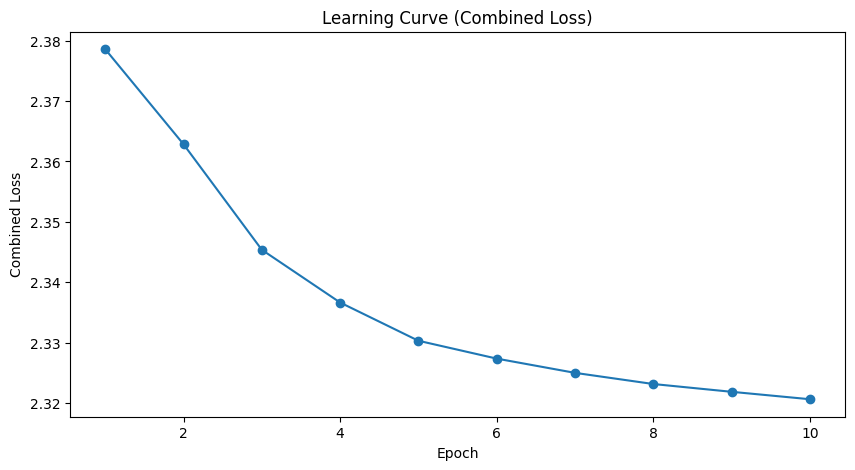

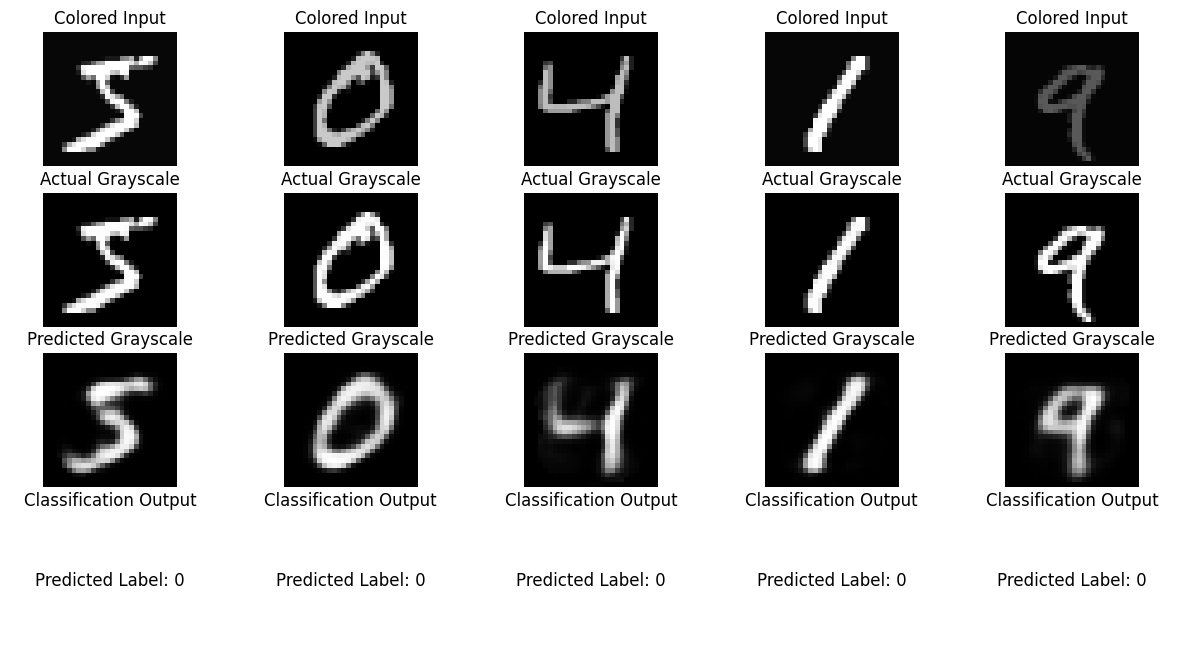

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os

# Set download path for datasets
data_path = "/content/sample_data"

# Custom Dataset for Colored MNIST
class ColoredMNISTDataset(Dataset):
    def __init__(self, grayscale_dataset):
        self.grayscale_dataset = grayscale_dataset
        self.transform_color = transforms.Compose([
            transforms.ToPILImage(),  # Convert tensor to PIL image
            transforms.Grayscale(num_output_channels=3),  # Replicate grayscale to RGB
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # Add random color jitter
            transforms.ToTensor()  # Convert back to tensor
        ])

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image = self.transform_color(grayscale_image)
        return color_image, grayscale_image

# Load Grayscale MNIST
grayscale_transform = transforms.ToTensor()
grayscale_mnist = MNIST(root=data_path, train=True, download=True, transform=grayscale_transform)

# Load Colored MNIST
colored_mnist = ColoredMNISTDataset(grayscale_mnist)

# DataLoader
batch_size = 64
train_loader = DataLoader(colored_mnist, batch_size=batch_size, shuffle=True)

# CNN Model for Multi-Task Learning
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_classification = nn.Linear(128, 10)  # Classification output (10 classes for MNIST digits)
        self.fc_regression = nn.Linear(128, 28 * 28)  # Regression output (28x28 grayscale image)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers_shared(x)
        classification_output = self.fc_classification(x)
        regression_output = torch.sigmoid(self.fc_regression(x)).view(-1, 1, 28, 28)
        return classification_output, regression_output

# Instantiate Model, Loss, and Optimizer
model = MultiTaskModel()
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function with Separate and Combined Losses
def train_multi_task(model, dataloader, classification_criterion, regression_criterion, optimizer, epochs=10, alpha=1.0, beta=1.0):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for color_imgs, gray_imgs in dataloader:
            gray_imgs = gray_imgs.to(torch.float32)
            color_imgs = color_imgs
            labels = torch.randint(0, 10, (color_imgs.size(0),))  # Random dummy labels for classification task

            optimizer.zero_grad()
            classification_output, regression_output = model(color_imgs)

            # Separate Losses
            classification_loss = classification_criterion(classification_output, labels)
            regression_loss = regression_criterion(regression_output, gray_imgs)

            # Combined Loss
            loss = alpha * classification_loss + beta * regression_loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    return losses

# Training the model
epochs = 10
alpha, beta = 1.0, 1.0  # Weighting coefficients for combined loss
losses = train_multi_task(model, train_loader, classification_criterion, regression_criterion, optimizer, epochs, alpha, beta)

# Plotting Learning Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Learning Curve (Combined Loss)')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.show()

# Visualize Predictions
def show_multi_task_predictions(model, dataset, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 8))
    for i in range(num_samples):
        color_img, gray_img = dataset[i]
        color_img = color_img.unsqueeze(0)
        with torch.no_grad():
            classification_output, predicted_gray_img = model(color_img)
            predicted_gray_img = predicted_gray_img.squeeze().cpu().numpy()
            predicted_label = classification_output.argmax(dim=1).item()

        axes[0, i].imshow(color_img[0].permute(1, 2, 0).numpy())
        axes[0, i].set_title("Colored Input")
        axes[0, i].axis('off')

        axes[1, i].imshow(gray_img[0], cmap='gray')
        axes[1, i].set_title("Actual Grayscale")
        axes[1, i].axis('off')

        axes[2, i].imshow(predicted_gray_img, cmap='gray')
        axes[2, i].set_title("Predicted Grayscale")
        axes[2, i].axis('off')

        axes[3, i].text(0.5, 0.5, f"Predicted Label: {predicted_label}", fontsize=12, ha='center', va='center')
        axes[3, i].set_title("Classification Output")
        axes[3, i].axis('off')
    plt.show()

# Show predictions
show_multi_task_predictions(model, colored_mnist)
